In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader

torch.cuda.is_available()

/media/imsanskar/My_files/Projects/Minor/env/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [2]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 256
image_width = 256

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
                                         num_workers = no_of_workers)

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [5]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [7]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # unet connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Model Train

In [9]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# check if cuda is avialbale
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)

# initialize weights if the model is not found in the paths
if os.path.exists("saved_models/generator.pth"):
    print("Generator Found")
    generator.load_state_dict(torch.load("saved_models/generator_loss_weight_100.pth", map_location = device))
else:
    generator.apply(weights_init_normal)
                                         
if os.path.exists("saved_models/discriminator.pth"):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth", map_location = device))
else:
    discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss() # mean squared loss
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

False
Generator Found
Discriminator Found


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((512, 512)) # Resize the image to constant size
])

# create a dataloader
pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

dataloader = DataLoader(
    pair_image_dataloader,
    batch_size = 10,
    shuffle = True
)

val_pair_image_dataloader = img_dataloader.ImageDataset("./data/val/old_image", "./data/val/reconstructed_image", transform)

torch.cuda.empty_cache()

In [ ]:
for epoch in range(10):
    for i, batch in tqdm(enumerate(dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # total loss of the generator
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator
        
        loss_D.backward()
        optimier_D.step()
        
        # for logging
        print(f"Generator Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
        print(f"Discriminator Error: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")
        
        # train with only 5000 images
        if i % 500 ==  0 and i > 0:
            break
            
        torch.cuda.empty_cache()

1it [00:00,  1.26it/s]

Generator Error: 3.881650447845459, epoch: 0, itr: 0
Discriminator Error: 3.614795787143521e-05, epoch: 0, itr: 0


2it [00:01,  1.68it/s]

Generator Error: 3.6925461292266846, epoch: 0, itr: 1
Discriminator Error: 0.00021852740610484034, epoch: 0, itr: 1


3it [00:01,  1.88it/s]

Generator Error: 4.091390609741211, epoch: 0, itr: 2
Discriminator Error: 2.8102742362534627e-05, epoch: 0, itr: 2


4it [00:02,  1.98it/s]

Generator Error: 3.2444841861724854, epoch: 0, itr: 3
Discriminator Error: 0.00017743298667483032, epoch: 0, itr: 3


5it [00:02,  2.04it/s]

Generator Error: 3.5574920177459717, epoch: 0, itr: 4
Discriminator Error: 1.3440539987641387e-05, epoch: 0, itr: 4


6it [00:03,  2.08it/s]

Generator Error: 3.4340829849243164, epoch: 0, itr: 5
Discriminator Error: 4.769437509821728e-05, epoch: 0, itr: 5


7it [00:03,  2.11it/s]

Generator Error: 3.276756763458252, epoch: 0, itr: 6
Discriminator Error: 0.0005376425688154995, epoch: 0, itr: 6


8it [00:04,  2.12it/s]

Generator Error: 3.194305896759033, epoch: 0, itr: 7
Discriminator Error: 6.176729948492721e-05, epoch: 0, itr: 7


9it [00:04,  2.12it/s]

Generator Error: 4.036940097808838, epoch: 0, itr: 8
Discriminator Error: 0.0001377252337988466, epoch: 0, itr: 8


10it [00:04,  2.11it/s]

Generator Error: 3.4791064262390137, epoch: 0, itr: 9
Discriminator Error: 0.001974687213078141, epoch: 0, itr: 9


11it [00:05,  2.11it/s]

Generator Error: 3.407857656478882, epoch: 0, itr: 10
Discriminator Error: 6.66827181703411e-05, epoch: 0, itr: 10


12it [00:05,  2.12it/s]

Generator Error: 3.224374771118164, epoch: 0, itr: 11
Discriminator Error: 5.910848267376423e-05, epoch: 0, itr: 11


13it [00:06,  2.12it/s]

Generator Error: 3.4464335441589355, epoch: 0, itr: 12
Discriminator Error: 1.9052280549658462e-05, epoch: 0, itr: 12


14it [00:06,  2.14it/s]

Generator Error: 3.699249267578125, epoch: 0, itr: 13
Discriminator Error: 6.166060484247282e-05, epoch: 0, itr: 13


15it [00:07,  2.14it/s]

Generator Error: 3.579132318496704, epoch: 0, itr: 14
Discriminator Error: 5.5524295021314174e-05, epoch: 0, itr: 14


16it [00:07,  2.16it/s]

Generator Error: 3.5163540840148926, epoch: 0, itr: 15
Discriminator Error: 0.0001225851447088644, epoch: 0, itr: 15


17it [00:08,  2.16it/s]

Generator Error: 3.2384183406829834, epoch: 0, itr: 16
Discriminator Error: 0.00019486231030896306, epoch: 0, itr: 16


18it [00:08,  2.16it/s]

Generator Error: 3.1382129192352295, epoch: 0, itr: 17
Discriminator Error: 0.00035993181518279016, epoch: 0, itr: 17


19it [00:09,  2.16it/s]

Generator Error: 3.205991268157959, epoch: 0, itr: 18
Discriminator Error: 6.103984924266115e-05, epoch: 0, itr: 18


20it [00:09,  2.16it/s]

Generator Error: 3.6184842586517334, epoch: 0, itr: 19
Discriminator Error: 1.3638195014209487e-05, epoch: 0, itr: 19


21it [00:10,  2.16it/s]

Generator Error: 4.472681045532227, epoch: 0, itr: 20
Discriminator Error: 1.7999591364059597e-05, epoch: 0, itr: 20


22it [00:10,  2.16it/s]

Generator Error: 3.6260886192321777, epoch: 0, itr: 21
Discriminator Error: 6.433646194636822e-05, epoch: 0, itr: 21


23it [00:11,  2.15it/s]

Generator Error: 3.810338020324707, epoch: 0, itr: 22
Discriminator Error: 0.00012300249363761395, epoch: 0, itr: 22


24it [00:11,  2.15it/s]

Generator Error: 3.224471092224121, epoch: 0, itr: 23
Discriminator Error: 3.0750852602068335e-06, epoch: 0, itr: 23


25it [00:11,  2.16it/s]

Generator Error: 3.0968737602233887, epoch: 0, itr: 24
Discriminator Error: 7.022164936643094e-05, epoch: 0, itr: 24


26it [00:12,  2.17it/s]

Generator Error: 3.8936946392059326, epoch: 0, itr: 25
Discriminator Error: 8.608776624896564e-06, epoch: 0, itr: 25


27it [00:12,  2.15it/s]

Generator Error: 4.05046272277832, epoch: 0, itr: 26
Discriminator Error: 4.394014467834495e-05, epoch: 0, itr: 26


28it [00:13,  2.15it/s]

Generator Error: 3.8063018321990967, epoch: 0, itr: 27
Discriminator Error: 1.2744652849505655e-05, epoch: 0, itr: 27


29it [00:13,  2.16it/s]

Generator Error: 3.509019136428833, epoch: 0, itr: 28
Discriminator Error: 4.219638412905624e-06, epoch: 0, itr: 28


30it [00:14,  2.16it/s]

Generator Error: 3.1406474113464355, epoch: 0, itr: 29
Discriminator Error: 4.294275277061388e-05, epoch: 0, itr: 29


31it [00:14,  2.14it/s]

Generator Error: 3.3530666828155518, epoch: 0, itr: 30
Discriminator Error: 0.00012754727504216135, epoch: 0, itr: 30


32it [00:15,  2.13it/s]

Generator Error: 3.583062171936035, epoch: 0, itr: 31
Discriminator Error: 4.801708200830035e-05, epoch: 0, itr: 31


33it [00:15,  2.14it/s]

Generator Error: 3.3510842323303223, epoch: 0, itr: 32
Discriminator Error: 1.0232695785816759e-05, epoch: 0, itr: 32


34it [00:16,  2.15it/s]

Generator Error: 3.545707941055298, epoch: 0, itr: 33
Discriminator Error: 2.8890386602142826e-05, epoch: 0, itr: 33


35it [00:16,  2.15it/s]

Generator Error: 3.8256661891937256, epoch: 0, itr: 34
Discriminator Error: 3.4727527236100286e-05, epoch: 0, itr: 34


36it [00:17,  2.15it/s]

Generator Error: 3.8372244834899902, epoch: 0, itr: 35
Discriminator Error: 1.2587845958478283e-05, epoch: 0, itr: 35


37it [00:17,  2.14it/s]

Generator Error: 4.070149898529053, epoch: 0, itr: 36
Discriminator Error: 1.8431521311867982e-05, epoch: 0, itr: 36


38it [00:17,  2.13it/s]

Generator Error: 3.851571559906006, epoch: 0, itr: 37
Discriminator Error: 3.439981082919985e-05, epoch: 0, itr: 37


39it [00:18,  2.16it/s]

Generator Error: 3.6264607906341553, epoch: 0, itr: 38
Discriminator Error: 1.4112437384028453e-05, epoch: 0, itr: 38


40it [00:18,  2.14it/s]

Generator Error: 3.299950122833252, epoch: 0, itr: 39
Discriminator Error: 2.2764488676330075e-05, epoch: 0, itr: 39


41it [00:19,  2.15it/s]

Generator Error: 3.031505823135376, epoch: 0, itr: 40
Discriminator Error: 1.1833100870717317e-05, epoch: 0, itr: 40


42it [00:19,  2.13it/s]

Generator Error: 3.4060463905334473, epoch: 0, itr: 41
Discriminator Error: 9.230708201357629e-06, epoch: 0, itr: 41


43it [00:20,  2.14it/s]

Generator Error: 3.7290403842926025, epoch: 0, itr: 42
Discriminator Error: 8.205352060031146e-05, epoch: 0, itr: 42


44it [00:20,  2.16it/s]

Generator Error: 3.5793662071228027, epoch: 0, itr: 43
Discriminator Error: 2.6976143999490887e-05, epoch: 0, itr: 43


45it [00:21,  2.14it/s]

Generator Error: 3.383790969848633, epoch: 0, itr: 44
Discriminator Error: 3.7232832255540416e-05, epoch: 0, itr: 44


46it [00:21,  2.12it/s]

Generator Error: 4.096891403198242, epoch: 0, itr: 45
Discriminator Error: 1.258423799299635e-05, epoch: 0, itr: 45


47it [00:22,  2.14it/s]

Generator Error: 3.813018798828125, epoch: 0, itr: 46
Discriminator Error: 1.5185285519692115e-05, epoch: 0, itr: 46


48it [00:22,  2.14it/s]

Generator Error: 3.36580491065979, epoch: 0, itr: 47
Discriminator Error: 0.00023501041869167238, epoch: 0, itr: 47


49it [00:23,  2.15it/s]

Generator Error: 3.3466436862945557, epoch: 0, itr: 48
Discriminator Error: 1.0018145985668525e-05, epoch: 0, itr: 48


50it [00:23,  2.13it/s]

Generator Error: 3.472342014312744, epoch: 0, itr: 49
Discriminator Error: 3.139444379485212e-05, epoch: 0, itr: 49


51it [00:24,  2.12it/s]

Generator Error: 3.991708993911743, epoch: 0, itr: 50
Discriminator Error: 7.87259250500938e-06, epoch: 0, itr: 50


52it [00:24,  2.13it/s]

Generator Error: 3.6648550033569336, epoch: 0, itr: 51
Discriminator Error: 4.080151848029345e-05, epoch: 0, itr: 51


53it [00:25,  2.11it/s]

Generator Error: 4.043248176574707, epoch: 0, itr: 52
Discriminator Error: 0.00040563661605119705, epoch: 0, itr: 52


54it [00:25,  2.11it/s]

Generator Error: 3.641439914703369, epoch: 0, itr: 53
Discriminator Error: 9.09441769181285e-06, epoch: 0, itr: 53


55it [00:25,  2.13it/s]

Generator Error: 3.2064788341522217, epoch: 0, itr: 54
Discriminator Error: 0.0004234306397847831, epoch: 0, itr: 54


56it [00:26,  2.14it/s]

Generator Error: 3.1273813247680664, epoch: 0, itr: 55
Discriminator Error: 6.914574896654813e-06, epoch: 0, itr: 55


57it [00:26,  2.14it/s]

Generator Error: 4.002664089202881, epoch: 0, itr: 56
Discriminator Error: 1.8041864677798003e-05, epoch: 0, itr: 56


58it [00:27,  2.13it/s]

Generator Error: 3.5070271492004395, epoch: 0, itr: 57
Discriminator Error: 4.4174357753945515e-06, epoch: 0, itr: 57


59it [00:27,  2.12it/s]

Generator Error: 3.9517788887023926, epoch: 0, itr: 58
Discriminator Error: 4.683904080593493e-06, epoch: 0, itr: 58


60it [00:28,  2.12it/s]

Generator Error: 3.0032432079315186, epoch: 0, itr: 59
Discriminator Error: 0.0002896418736781925, epoch: 0, itr: 59


61it [00:28,  2.13it/s]

Generator Error: 3.2140848636627197, epoch: 0, itr: 60
Discriminator Error: 4.7657638788223267e-05, epoch: 0, itr: 60


62it [00:29,  2.13it/s]

Generator Error: 4.246454238891602, epoch: 0, itr: 61
Discriminator Error: 6.582769128726795e-05, epoch: 0, itr: 61


63it [00:29,  2.12it/s]

Generator Error: 3.6960256099700928, epoch: 0, itr: 62
Discriminator Error: 2.6479090593056753e-05, epoch: 0, itr: 62


64it [00:30,  2.14it/s]

Generator Error: 3.806220054626465, epoch: 0, itr: 63
Discriminator Error: 4.085632554051699e-06, epoch: 0, itr: 63


65it [00:30,  2.14it/s]

Generator Error: 3.2430918216705322, epoch: 0, itr: 64
Discriminator Error: 1.024590619636001e-05, epoch: 0, itr: 64


66it [00:31,  2.12it/s]

Generator Error: 3.9819538593292236, epoch: 0, itr: 65
Discriminator Error: 7.562600512756035e-05, epoch: 0, itr: 65


67it [00:31,  2.11it/s]

Generator Error: 2.910505771636963, epoch: 0, itr: 66
Discriminator Error: 4.796963548869826e-05, epoch: 0, itr: 66


68it [00:32,  2.12it/s]

Generator Error: 3.4237022399902344, epoch: 0, itr: 67
Discriminator Error: 1.212182905874215e-05, epoch: 0, itr: 67


69it [00:32,  2.13it/s]

Generator Error: 3.1257529258728027, epoch: 0, itr: 68
Discriminator Error: 5.774784222012386e-05, epoch: 0, itr: 68


70it [00:33,  2.14it/s]

Generator Error: 2.985689163208008, epoch: 0, itr: 69
Discriminator Error: 1.3424640201264992e-05, epoch: 0, itr: 69


71it [00:33,  2.12it/s]

Generator Error: 3.650725841522217, epoch: 0, itr: 70
Discriminator Error: 3.6518918932415545e-05, epoch: 0, itr: 70


72it [00:33,  2.09it/s]

Generator Error: 4.060842990875244, epoch: 0, itr: 71
Discriminator Error: 2.0120528461120557e-06, epoch: 0, itr: 71


73it [00:34,  2.10it/s]

Generator Error: 3.826472282409668, epoch: 0, itr: 72
Discriminator Error: 3.506906750772032e-06, epoch: 0, itr: 72


74it [00:34,  2.08it/s]

Generator Error: 3.5974130630493164, epoch: 0, itr: 73
Discriminator Error: 0.0018442857544869184, epoch: 0, itr: 73


75it [00:35,  2.10it/s]

Generator Error: 4.057671070098877, epoch: 0, itr: 74
Discriminator Error: 0.0006929144146852195, epoch: 0, itr: 74


76it [00:35,  2.12it/s]

Generator Error: 2.8921444416046143, epoch: 0, itr: 75
Discriminator Error: 0.00012381865235511214, epoch: 0, itr: 75


77it [00:36,  2.09it/s]

Generator Error: 4.128842830657959, epoch: 0, itr: 76
Discriminator Error: 7.696876855334267e-05, epoch: 0, itr: 76


78it [00:36,  2.10it/s]

Generator Error: 3.1802330017089844, epoch: 0, itr: 77
Discriminator Error: 9.015049727167934e-06, epoch: 0, itr: 77


79it [00:37,  2.09it/s]

Generator Error: 3.3430678844451904, epoch: 0, itr: 78
Discriminator Error: 0.012515479698777199, epoch: 0, itr: 78


80it [00:37,  2.10it/s]

Generator Error: 3.6752877235412598, epoch: 0, itr: 79
Discriminator Error: 0.02891196310520172, epoch: 0, itr: 79


81it [00:38,  2.10it/s]

Generator Error: 3.645759344100952, epoch: 0, itr: 80
Discriminator Error: 0.0002185706835007295, epoch: 0, itr: 80


82it [00:38,  2.10it/s]

Generator Error: 3.779452085494995, epoch: 0, itr: 81
Discriminator Error: 0.0009384488803334534, epoch: 0, itr: 81


83it [00:39,  2.09it/s]

Generator Error: 3.2355191707611084, epoch: 0, itr: 82
Discriminator Error: 0.012608589604496956, epoch: 0, itr: 82


84it [00:39,  2.11it/s]

Generator Error: 3.465719223022461, epoch: 0, itr: 83
Discriminator Error: 6.251196464290842e-05, epoch: 0, itr: 83


85it [00:40,  2.10it/s]

Generator Error: 3.814781427383423, epoch: 0, itr: 84
Discriminator Error: 0.00020572208450175822, epoch: 0, itr: 84


86it [00:40,  2.10it/s]

Generator Error: 3.6495118141174316, epoch: 0, itr: 85
Discriminator Error: 2.503119503671769e-05, epoch: 0, itr: 85


87it [00:41,  2.07it/s]

Generator Error: 3.727898597717285, epoch: 0, itr: 86
Discriminator Error: 2.7344583941157907e-05, epoch: 0, itr: 86


88it [00:41,  2.08it/s]

Generator Error: 3.736149311065674, epoch: 0, itr: 87
Discriminator Error: 7.873235153965652e-05, epoch: 0, itr: 87


89it [00:42,  2.09it/s]

Generator Error: 3.4786956310272217, epoch: 0, itr: 88
Discriminator Error: 0.00037036431604065, epoch: 0, itr: 88


90it [00:42,  2.10it/s]

Generator Error: 3.457380533218384, epoch: 0, itr: 89
Discriminator Error: 0.00011591993825277314, epoch: 0, itr: 89


91it [00:43,  2.11it/s]

Generator Error: 3.726942777633667, epoch: 0, itr: 90
Discriminator Error: 2.9134112992323935e-05, epoch: 0, itr: 90


92it [00:43,  2.12it/s]

Generator Error: 3.7268123626708984, epoch: 0, itr: 91
Discriminator Error: 7.742630259599537e-05, epoch: 0, itr: 91


93it [00:43,  2.13it/s]

Generator Error: 3.712132453918457, epoch: 0, itr: 92
Discriminator Error: 8.510227780789137e-05, epoch: 0, itr: 92


94it [00:44,  2.13it/s]

Generator Error: 3.344247341156006, epoch: 0, itr: 93
Discriminator Error: 0.00018522910249885172, epoch: 0, itr: 93


95it [00:44,  2.14it/s]

Generator Error: 3.031038761138916, epoch: 0, itr: 94
Discriminator Error: 0.0004297674458939582, epoch: 0, itr: 94


96it [00:45,  2.13it/s]

Generator Error: 3.305368661880493, epoch: 0, itr: 95
Discriminator Error: 1.636588785913773e-05, epoch: 0, itr: 95


97it [00:45,  2.13it/s]

Generator Error: 4.359295845031738, epoch: 0, itr: 96
Discriminator Error: 1.898877599160187e-05, epoch: 0, itr: 96


98it [00:46,  2.14it/s]

Generator Error: 3.3698689937591553, epoch: 0, itr: 97
Discriminator Error: 5.050157415098511e-05, epoch: 0, itr: 97


99it [00:46,  2.14it/s]

Generator Error: 3.1366467475891113, epoch: 0, itr: 98
Discriminator Error: 7.844666106393561e-05, epoch: 0, itr: 98


100it [00:47,  2.12it/s]
0it [00:00, ?it/s]

Generator Error: 3.60831880569458, epoch: 0, itr: 99
Discriminator Error: 3.100934191024862e-05, epoch: 0, itr: 99


1it [00:00,  2.13it/s]

Generator Error: 3.722834587097168, epoch: 1, itr: 0
Discriminator Error: 0.00021896962425671518, epoch: 1, itr: 0


2it [00:00,  2.14it/s]

Generator Error: 3.964775562286377, epoch: 1, itr: 1
Discriminator Error: 0.00024647152167744935, epoch: 1, itr: 1


3it [00:01,  2.13it/s]

Generator Error: 2.869419813156128, epoch: 1, itr: 2
Discriminator Error: 0.00023634510580450296, epoch: 1, itr: 2


4it [00:01,  2.13it/s]

Generator Error: 3.2567861080169678, epoch: 1, itr: 3
Discriminator Error: 0.00011103969882242382, epoch: 1, itr: 3


5it [00:02,  2.13it/s]

Generator Error: 3.5075886249542236, epoch: 1, itr: 4
Discriminator Error: 4.6484459744533524e-05, epoch: 1, itr: 4


6it [00:02,  2.14it/s]

Generator Error: 3.6533408164978027, epoch: 1, itr: 5
Discriminator Error: 8.091458585113287e-05, epoch: 1, itr: 5


7it [00:03,  2.12it/s]

Generator Error: 3.298687219619751, epoch: 1, itr: 6
Discriminator Error: 8.621966117061675e-05, epoch: 1, itr: 6


8it [00:03,  2.10it/s]

Generator Error: 4.135194778442383, epoch: 1, itr: 7
Discriminator Error: 2.6828904083231464e-05, epoch: 1, itr: 7


9it [00:04,  2.10it/s]

Generator Error: 3.3454198837280273, epoch: 1, itr: 8
Discriminator Error: 3.461044980213046e-05, epoch: 1, itr: 8


10it [00:04,  2.12it/s]

Generator Error: 3.5259313583374023, epoch: 1, itr: 9
Discriminator Error: 3.5369215765967965e-05, epoch: 1, itr: 9


11it [00:05,  2.12it/s]

Generator Error: 3.687689781188965, epoch: 1, itr: 10
Discriminator Error: 2.388775465078652e-05, epoch: 1, itr: 10


12it [00:05,  2.13it/s]

Generator Error: 4.356961250305176, epoch: 1, itr: 11
Discriminator Error: 3.358893081895076e-05, epoch: 1, itr: 11


13it [00:06,  2.12it/s]

Generator Error: 3.487534761428833, epoch: 1, itr: 12
Discriminator Error: 9.753704034665134e-06, epoch: 1, itr: 12


14it [00:06,  2.12it/s]

Generator Error: 3.2485225200653076, epoch: 1, itr: 13
Discriminator Error: 2.4086955818347633e-05, epoch: 1, itr: 13


15it [00:07,  2.11it/s]

Generator Error: 3.9880242347717285, epoch: 1, itr: 14
Discriminator Error: 3.2360774639528245e-05, epoch: 1, itr: 14


16it [00:07,  2.11it/s]

Generator Error: 3.3800904750823975, epoch: 1, itr: 15
Discriminator Error: 3.4247394069097936e-05, epoch: 1, itr: 15


17it [00:08,  2.12it/s]

Generator Error: 3.3648009300231934, epoch: 1, itr: 16
Discriminator Error: 0.0002785197866614908, epoch: 1, itr: 16


18it [00:08,  2.12it/s]

Generator Error: 3.7640979290008545, epoch: 1, itr: 17
Discriminator Error: 2.7369089366402477e-05, epoch: 1, itr: 17


19it [00:08,  2.12it/s]

Generator Error: 3.0204408168792725, epoch: 1, itr: 18
Discriminator Error: 6.417166150640696e-05, epoch: 1, itr: 18


20it [00:09,  2.13it/s]

Generator Error: 3.0339925289154053, epoch: 1, itr: 19
Discriminator Error: 0.0005203260225243866, epoch: 1, itr: 19


21it [00:09,  2.13it/s]

Generator Error: 3.291633129119873, epoch: 1, itr: 20
Discriminator Error: 1.286987571802456e-05, epoch: 1, itr: 20


22it [00:10,  2.14it/s]

Generator Error: 3.5535831451416016, epoch: 1, itr: 21
Discriminator Error: 9.084021439775825e-05, epoch: 1, itr: 21


23it [00:10,  2.13it/s]

Generator Error: 3.3623790740966797, epoch: 1, itr: 22
Discriminator Error: 0.00010902509529842064, epoch: 1, itr: 22


24it [00:11,  2.12it/s]

Generator Error: 3.088329315185547, epoch: 1, itr: 23
Discriminator Error: 1.8888993508880958e-05, epoch: 1, itr: 23


25it [00:11,  2.12it/s]

Generator Error: 3.409127712249756, epoch: 1, itr: 24
Discriminator Error: 2.4958122594398446e-05, epoch: 1, itr: 24


26it [00:12,  2.11it/s]

Generator Error: 3.9205615520477295, epoch: 1, itr: 25
Discriminator Error: 0.0004881716158706695, epoch: 1, itr: 25


27it [00:12,  2.10it/s]

Generator Error: 3.449446201324463, epoch: 1, itr: 26
Discriminator Error: 0.00032386076054535806, epoch: 1, itr: 26


28it [00:13,  2.10it/s]

Generator Error: 3.7548744678497314, epoch: 1, itr: 27
Discriminator Error: 4.476160756894387e-05, epoch: 1, itr: 27


29it [00:13,  2.11it/s]

Generator Error: 3.5895180702209473, epoch: 1, itr: 28
Discriminator Error: 2.032240263361018e-05, epoch: 1, itr: 28


30it [00:14,  2.10it/s]

Generator Error: 2.9677679538726807, epoch: 1, itr: 29
Discriminator Error: 0.00047138522495515645, epoch: 1, itr: 29


31it [00:14,  2.10it/s]

Generator Error: 3.241777181625366, epoch: 1, itr: 30
Discriminator Error: 5.445468195830472e-05, epoch: 1, itr: 30


32it [00:15,  2.10it/s]

Generator Error: 4.2176947593688965, epoch: 1, itr: 31
Discriminator Error: 2.8436370484996587e-05, epoch: 1, itr: 31


33it [00:15,  2.11it/s]

Generator Error: 3.540806531906128, epoch: 1, itr: 32
Discriminator Error: 0.00017118715913966298, epoch: 1, itr: 32


34it [00:16,  2.12it/s]

Generator Error: 2.8718018531799316, epoch: 1, itr: 33
Discriminator Error: 3.4029450034722686e-05, epoch: 1, itr: 33


35it [00:16,  2.11it/s]

Generator Error: 3.498741865158081, epoch: 1, itr: 34
Discriminator Error: 4.7070745495148e-05, epoch: 1, itr: 34


36it [00:17,  2.10it/s]

Generator Error: 3.7210631370544434, epoch: 1, itr: 35
Discriminator Error: 1.8888782506110147e-05, epoch: 1, itr: 35


37it [00:17,  2.10it/s]

Generator Error: 4.140812397003174, epoch: 1, itr: 36
Discriminator Error: 3.238240606151521e-05, epoch: 1, itr: 36


38it [00:17,  2.11it/s]

Generator Error: 3.4517741203308105, epoch: 1, itr: 37
Discriminator Error: 2.6242178137181327e-05, epoch: 1, itr: 37


39it [00:18,  2.11it/s]

Generator Error: 2.8175690174102783, epoch: 1, itr: 38
Discriminator Error: 1.4074769751459826e-05, epoch: 1, itr: 38


40it [00:18,  2.12it/s]

Generator Error: 3.7582640647888184, epoch: 1, itr: 39
Discriminator Error: 2.8708054742310196e-05, epoch: 1, itr: 39


41it [00:19,  2.11it/s]

Generator Error: 3.8321633338928223, epoch: 1, itr: 40
Discriminator Error: 4.783764779858757e-06, epoch: 1, itr: 40


42it [00:19,  2.12it/s]

Generator Error: 2.957213878631592, epoch: 1, itr: 41
Discriminator Error: 0.00010762643796624616, epoch: 1, itr: 41


43it [00:20,  2.11it/s]

Generator Error: 3.745096206665039, epoch: 1, itr: 42
Discriminator Error: 2.0696974388556555e-05, epoch: 1, itr: 42


44it [00:20,  2.12it/s]

Generator Error: 3.3163113594055176, epoch: 1, itr: 43
Discriminator Error: 7.5998009378963616e-06, epoch: 1, itr: 43


45it [00:21,  2.12it/s]

Generator Error: 3.5995383262634277, epoch: 1, itr: 44
Discriminator Error: 0.00010848452802747488, epoch: 1, itr: 44


46it [00:21,  2.13it/s]

Generator Error: 2.8808205127716064, epoch: 1, itr: 45
Discriminator Error: 0.0003656837798189372, epoch: 1, itr: 45


47it [00:22,  2.13it/s]

Generator Error: 3.677671432495117, epoch: 1, itr: 46
Discriminator Error: 3.343003481859341e-05, epoch: 1, itr: 46


48it [00:22,  2.12it/s]

Generator Error: 3.391352891921997, epoch: 1, itr: 47
Discriminator Error: 6.452438537962735e-05, epoch: 1, itr: 47


49it [00:23,  2.11it/s]

Generator Error: 3.6031477451324463, epoch: 1, itr: 48
Discriminator Error: 2.458166090946179e-05, epoch: 1, itr: 48


50it [00:23,  2.11it/s]

Generator Error: 3.249222993850708, epoch: 1, itr: 49
Discriminator Error: 6.844342715339735e-05, epoch: 1, itr: 49


51it [00:24,  2.11it/s]

Generator Error: 3.8555922508239746, epoch: 1, itr: 50
Discriminator Error: 2.4036726244958118e-05, epoch: 1, itr: 50


52it [00:24,  2.12it/s]

Generator Error: 3.610525369644165, epoch: 1, itr: 51
Discriminator Error: 5.154508835403249e-05, epoch: 1, itr: 51


53it [00:25,  2.12it/s]

Generator Error: 3.5644097328186035, epoch: 1, itr: 52
Discriminator Error: 4.98532026540488e-05, epoch: 1, itr: 52


54it [00:25,  2.11it/s]

Generator Error: 3.634294033050537, epoch: 1, itr: 53
Discriminator Error: 1.7319242033408955e-05, epoch: 1, itr: 53


55it [00:26,  2.11it/s]

Generator Error: 3.8607165813446045, epoch: 1, itr: 54
Discriminator Error: 2.7917685656575486e-05, epoch: 1, itr: 54


56it [00:26,  2.10it/s]

Generator Error: 3.8833940029144287, epoch: 1, itr: 55
Discriminator Error: 2.221595059381798e-05, epoch: 1, itr: 55


57it [00:26,  2.10it/s]

Generator Error: 3.6065425872802734, epoch: 1, itr: 56
Discriminator Error: 1.768355468811933e-05, epoch: 1, itr: 56


58it [00:27,  2.11it/s]

Generator Error: 3.508876323699951, epoch: 1, itr: 57
Discriminator Error: 0.00020337459864094853, epoch: 1, itr: 57


59it [00:27,  2.11it/s]

Generator Error: 3.9863357543945312, epoch: 1, itr: 58
Discriminator Error: 3.9050755731295794e-05, epoch: 1, itr: 58


60it [00:28,  2.11it/s]

Generator Error: 3.5977494716644287, epoch: 1, itr: 59
Discriminator Error: 1.84221935342066e-05, epoch: 1, itr: 59


61it [00:28,  2.10it/s]

Generator Error: 4.091568470001221, epoch: 1, itr: 60
Discriminator Error: 3.0158133085933514e-05, epoch: 1, itr: 60


62it [00:29,  2.11it/s]

Generator Error: 3.554202079772949, epoch: 1, itr: 61
Discriminator Error: 1.5650290151825175e-05, epoch: 1, itr: 61


63it [00:29,  2.10it/s]

Generator Error: 4.0449395179748535, epoch: 1, itr: 62
Discriminator Error: 6.077794751035981e-06, epoch: 1, itr: 62


64it [00:30,  2.11it/s]

Generator Error: 3.5188400745391846, epoch: 1, itr: 63
Discriminator Error: 1.1505935617606156e-05, epoch: 1, itr: 63


65it [00:30,  2.11it/s]

Generator Error: 3.3265693187713623, epoch: 1, itr: 64
Discriminator Error: 9.980846698454116e-06, epoch: 1, itr: 64


66it [00:31,  2.12it/s]

Generator Error: 3.180311679840088, epoch: 1, itr: 65
Discriminator Error: 1.657032589719165e-05, epoch: 1, itr: 65


67it [00:31,  2.11it/s]

Generator Error: 3.818148612976074, epoch: 1, itr: 66
Discriminator Error: 7.236756573547609e-06, epoch: 1, itr: 66


68it [00:32,  2.11it/s]

Generator Error: 3.1388795375823975, epoch: 1, itr: 67
Discriminator Error: 2.709656473598443e-05, epoch: 1, itr: 67


69it [00:32,  2.11it/s]

Generator Error: 3.1473617553710938, epoch: 1, itr: 68
Discriminator Error: 1.0572677638265304e-05, epoch: 1, itr: 68


70it [00:33,  2.11it/s]

Generator Error: 3.3406946659088135, epoch: 1, itr: 69
Discriminator Error: 4.819739478989504e-05, epoch: 1, itr: 69


71it [00:33,  2.11it/s]

Generator Error: 3.5194437503814697, epoch: 1, itr: 70
Discriminator Error: 1.4809167623752728e-05, epoch: 1, itr: 70


72it [00:34,  2.10it/s]

Generator Error: 3.7644495964050293, epoch: 1, itr: 71
Discriminator Error: 1.721286571410019e-05, epoch: 1, itr: 71


73it [00:34,  2.10it/s]

Generator Error: 3.050095796585083, epoch: 1, itr: 72
Discriminator Error: 3.899918738170527e-05, epoch: 1, itr: 72


74it [00:35,  2.11it/s]

Generator Error: 3.4656760692596436, epoch: 1, itr: 73
Discriminator Error: 1.6859088646015152e-05, epoch: 1, itr: 73


75it [00:35,  2.10it/s]

Generator Error: 3.632662296295166, epoch: 1, itr: 74
Discriminator Error: 4.330576484790072e-05, epoch: 1, itr: 74


76it [00:35,  2.11it/s]

Generator Error: 3.478074312210083, epoch: 1, itr: 75
Discriminator Error: 2.4032911824178882e-05, epoch: 1, itr: 75


77it [00:36,  2.11it/s]

Generator Error: 3.4865238666534424, epoch: 1, itr: 76
Discriminator Error: 4.610130417859182e-05, epoch: 1, itr: 76


78it [00:36,  2.11it/s]

Generator Error: 3.411020040512085, epoch: 1, itr: 77
Discriminator Error: 3.446648042881861e-05, epoch: 1, itr: 77


79it [00:37,  2.08it/s]

Generator Error: 3.670121669769287, epoch: 1, itr: 78
Discriminator Error: 1.756645542627666e-05, epoch: 1, itr: 78


80it [00:37,  2.09it/s]

Generator Error: 3.3410491943359375, epoch: 1, itr: 79
Discriminator Error: 5.876766408619005e-06, epoch: 1, itr: 79


81it [00:38,  2.08it/s]

Generator Error: 3.6349122524261475, epoch: 1, itr: 80
Discriminator Error: 1.1883571460202802e-05, epoch: 1, itr: 80


82it [00:38,  2.09it/s]

Generator Error: 3.446061372756958, epoch: 1, itr: 81
Discriminator Error: 8.100306149572134e-05, epoch: 1, itr: 81


83it [00:39,  2.07it/s]

Generator Error: 3.704432249069214, epoch: 1, itr: 82
Discriminator Error: 7.781311978760641e-06, epoch: 1, itr: 82


84it [00:39,  2.09it/s]

Generator Error: 3.6307199001312256, epoch: 1, itr: 83
Discriminator Error: 2.1928790374659002e-05, epoch: 1, itr: 83


85it [00:40,  2.09it/s]

Generator Error: 3.4344377517700195, epoch: 1, itr: 84
Discriminator Error: 8.885570423444733e-06, epoch: 1, itr: 84


86it [00:40,  2.10it/s]

Generator Error: 3.754777431488037, epoch: 1, itr: 85
Discriminator Error: 2.2708640244673006e-05, epoch: 1, itr: 85


87it [00:41,  2.09it/s]

Generator Error: 3.299129009246826, epoch: 1, itr: 86
Discriminator Error: 5.171050361241214e-05, epoch: 1, itr: 86


88it [00:41,  2.09it/s]

Generator Error: 2.867337942123413, epoch: 1, itr: 87
Discriminator Error: 3.3746833651093766e-05, epoch: 1, itr: 87


89it [00:42,  2.08it/s]

Generator Error: 3.7652933597564697, epoch: 1, itr: 88
Discriminator Error: 9.228198177879676e-05, epoch: 1, itr: 88


90it [00:42,  2.08it/s]

Generator Error: 3.5890822410583496, epoch: 1, itr: 89
Discriminator Error: 2.6041818273370154e-05, epoch: 1, itr: 89


91it [00:43,  2.07it/s]

Generator Error: 4.061903953552246, epoch: 1, itr: 90
Discriminator Error: 6.090898750699125e-06, epoch: 1, itr: 90


92it [00:43,  2.06it/s]

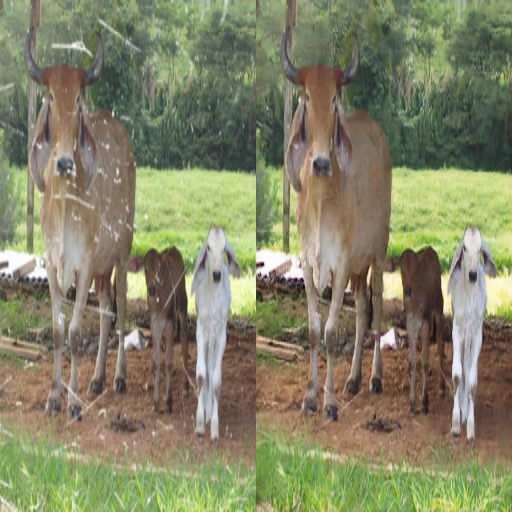

In [12]:
generator.load_state_dict(torch.load("saved_models/generator_test.pth", map_location = device))
test_image_index = 80

generated_image = generator(val_pair_image_dataloader[test_image_index]['A'].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
output_image = image_manipulation.np_to_pil(
    generated_image
)
# print(torch.norm(discriminator(
#     generated_image, 
#     pair_image_dataloader[test_image_index]['B']
# )))
original_image = image_manipulation.np_to_pil(
    val_pair_image_dataloader[test_image_index]['A'].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

new_image.resize((512, 512))

In [28]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [95]:
os.path.exists("saved_models/generator.pth")

True